# Comparison of 10X Nucleus vs. Segger for Cell Type Capture

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from requirements import *
from segger.data.parquet._utils import (
    read_parquet_region,
    filter_transcripts,
    load_settings,
)
from sg_utils.tl.xenium_utils import anndata_from_transcripts
from sg_utils.pp.preprocess_rapids import *
from sg_utils.pl.plot_embedding import plot_embedding
from sg_utils.pl.utils import lighten_color
from sg_utils.pl.plot_volcano import plot_volcano
from adjustText import adjust_text
import celltypist as ct
import gseapy
import hotspot
from scipy.cluster.hierarchy import leaves_list

from tifffile import TiffFile, imread, xml2dict
import zarr

# Plotting imports
from matplotlib.patches import Polygon
from matplotlib.collections import PolyCollection

## Setup: Import Datasets

In [3]:
# Read in AnnDatas
dataset = 'xenium_colon'

name = 'segger'
ad_seg = sc.read_h5ad(data_dir / dataset / f'h5ads/{name}_processed.h5ad')

name = '10x_nucleus'
ad_nuc = sc.read_h5ad(data_dir / dataset / f'h5ads/{name}_processed.h5ad')

name = '10x_cell'
ad_10x = sc.read_h5ad(data_dir / dataset / f'h5ads/{name}_processed.h5ad')

## Inflammatory Signals in Colon

### Figure 4A: UMAP

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4.25, 4.25))
_ = plot_embedding(
    ad_seg,
    'cell_type_level_1',
    s=0.6,
    legend_loc='on data',
    legend_fontsize=6,
    legend_fontweight='regular',
    palette=named_colors['Cell Type'],
    rasterized=True,
    alpha=0.5,
    ax=ax,
)
ax.set_title('')
fig.savefig(media_dir / dataset / 'segger_cell_type_umap.svg', dpi=300)
plt.close()

### Figure 4B: Spatial Plot

In [4]:
# Custom palette
palette = named_colors['Cell Type'].copy()
palette['Neutrophil'] = 'w'

Text(0.5, 1.0, '')

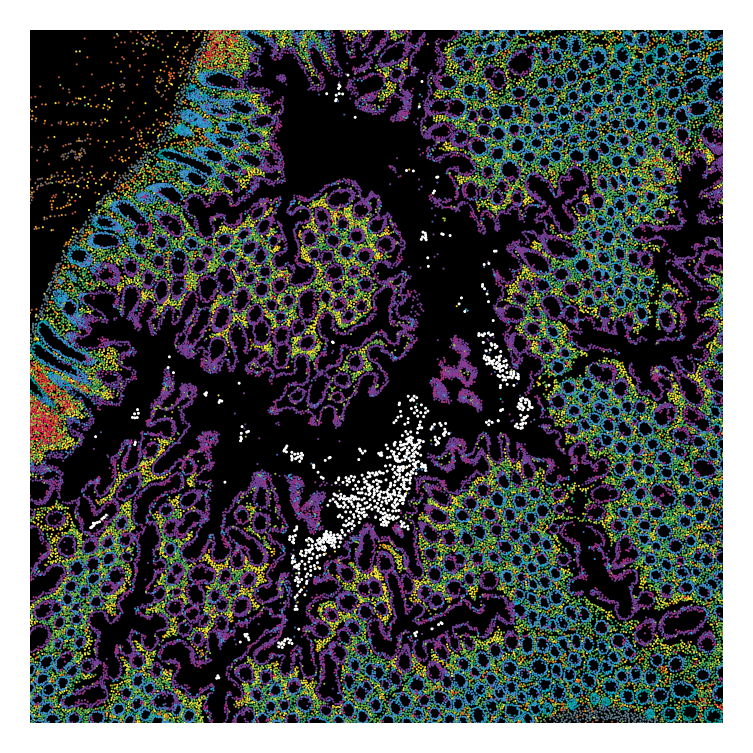

In [8]:
# Spatial subset
xmin = 4100
xmax = 6700
ymin = 3500
ymax = 6100

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
shared_kwargs = dict(
    features='cell_type_level_1',
    basis='X_spatial',
    palette=palette,
    rasterized=True,
    legend_loc='',
    ax=ax,
)

_ = plot_embedding(ad_seg, s=1, **shared_kwargs)
mask = ad_seg.obs['cell_type_level_1'].eq('Neutrophil')
_ = plot_embedding(ad_seg[mask], s=2, **shared_kwargs)

# Formatting
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_facecolor('k')
ax.set_title('')

# Save
fig.savefig(media_dir / dataset / f'segger_cell_type_space.svg', dpi=300)
plt.close()

### HotSpot Analysis

In [4]:
# Run HotSpot on Segger Data in Space
ad_seg.layers['raw'] = ad_seg.raw.X.copy()
sc.pp.filter_genes(ad_seg, min_counts=5)

hs = hotspot.Hotspot(ad_seg, 'raw', 'danb', 'X_spatial')
hs.create_knn_graph(weighted_graph=False, n_neighbors=20)
hs.compute_autocorrelations()
hs_genes = hs.results.loc[hs.results.FDR < 0.01].index
hs.compute_local_correlations(hs_genes, jobs=28)
hs.create_modules(3, False, 0.01)
hs.calculate_module_scores()

# Add to AnnData
lcz = pd.DataFrame(np.nan, ad_seg.var.index, ad_seg.var.index)
lcz.loc[hs_genes, hs_genes] = hs.local_correlation_z
ad_seg.varm['hotspot_local_correlation_z'] = lcz
ad_seg.var['hotspot_module'] = hs.modules
ad_seg.obs['module_' + hs.module_scores.columns.astype(str)] = hs.module_scores

100%|██████████| 425/425 [00:16<00:00, 26.44it/s]


Computing pair-wise local correlation on 421 features...


100%|██████████| 88410/88410 [01:34<00:00, 932.17it/s] 


Computing scores for 39 modules...


100%|██████████| 39/39 [00:16<00:00,  2.37it/s]


### Supp. Figure 1C

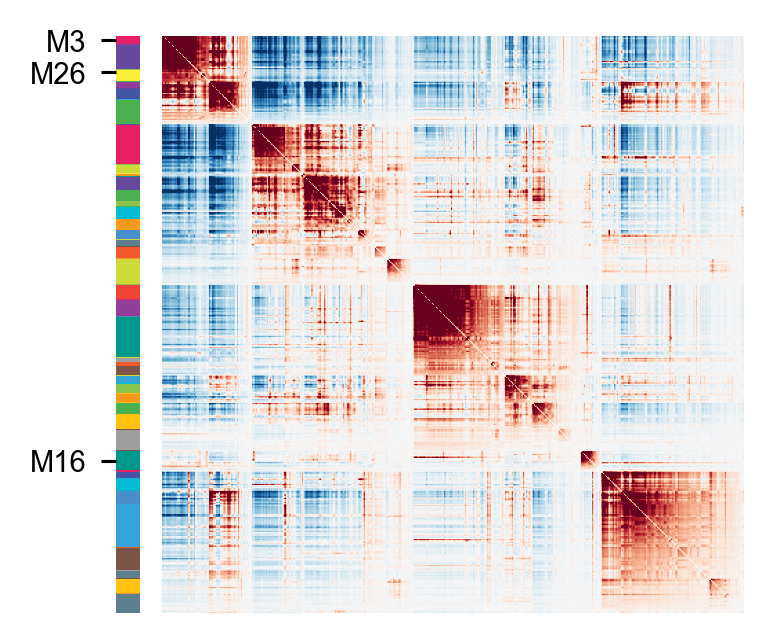

In [139]:
width_ratios = [0.1, 2.5]
wspace = 0.1 / np.mean(width_ratios)
gs_kw = dict(wspace=wspace, width_ratios=width_ratios)
w = np.sum(width_ratios) + 0.1
h = 2.5

fig, axes = plt.subplots(1, 2, figsize=(w, h), gridspec_kw=gs_kw)

# Plot Heatmap
ax = axes[1]
row_order = leaves_list(hs.linkage)
ax.imshow(
    hs.local_correlation_z.iloc[row_order, row_order],
    vmin=-100, 
    vmax=100, 
    cmap='RdBu_r', 
    aspect='auto',
    rasterized=True,
)
ax.axis("Off")

# Plot colors
ax = axes[0]
modules_order = hs.modules.iloc[row_order]
ax.imshow(
    modules_order.values.reshape(-1, 1),
    aspect='auto',
    cmap=cmap,
    rasterized=True,
)

yticks = []
modules = [16, 26, 3]
for m in modules:
    yticks.append(np.arange(row_order.shape[0])[modules_order.eq(m)].mean())
ax.set_yticks(yticks, [f'M{m}' for m in modules])
ax.spines[list(ax.spines)].set_visible(False)
ax.xaxis.set_visible(False)
ax.tick_params(width=0.75, labelsize=7)
fig.patch.set_alpha(0)
fig.savefig(media_dir / dataset / 'hotspot_heatmap.svg')

In [143]:
# Custom colorbar plot
fig, ax = plt.subplots(1, 1, figsize=(0.75, 0.15))
cmap = sns.color_palette('RdBu_r', as_cmap=True)
img = np.array([[cmap(n) for n in np.linspace(0, 1, 255)]])
ax.imshow(img, aspect='auto')
ax.axis('off')
fig.savefig(media_dir / dataset / f'supp_fig4c_colorbar.svg', dpi=300)
plt.close()

### HotSpot Modules vs. Neutrophil Distance

In [6]:
# Compute kNN on space with wide window
nearest_neighbors(ad_seg, 500, use_rep='X_spatial', key_added='neutro')

# Find distance of each cell to nearest neutrophil
ad_seg.obs['dist_nearest_neutrophil'] = np.nan
is_neutrophil = ad_seg.obs['cell_type_level_1'].eq('Neutrophil')
neutro_dists = ad_seg.obsp['neutro_distances'].T[is_neutrophil].T
i, j = neutro_dists.nonzero()
i, idx = np.unique(i, return_index=True)
j = j[idx]
dists = neutro_dists[i, j].A[0]
ad_seg.obs.loc[ad_seg.obs.index[i], 'dist_nearest_neutrophil'] = dists

In [7]:
# Correlations of neutrophil distance and module score
module_cols = ad_seg.obs.columns[ad_seg.obs.columns.str.contains('module')]
module_corr = pd.DataFrame(index=module_cols, columns=['R', 'pval'])

mask = ad_seg.obs['cell_type_level_2'].eq('Epithelial')
mask &= ~ad_seg.obs['dist_nearest_neutrophil'].isna()
a = ad_seg.obs.loc[mask, 'dist_nearest_neutrophil']
for mod in module_cols:
    b = ad_seg.obs.loc[mask, mod]
    module_corr.loc[mod] = sp.stats.spearmanr(a, b)

In [8]:
# Modules to focus on
module_corr.loc[['module_16', 'module_26', 'module_3']]

,R,pval
module_16,-0.389902,0.0
module_26,-0.243306,0.0
module_3,-0.017958,0.046473


In [9]:
hs.modules.loc[['IL1B', 'DUOX2', 'SLC26A3']]

IL1B       16
DUOX2      26
SLC26A3     3
Name: Module, dtype: int64

### Supp. Figure 1D-E

In [10]:
# Custom cmap
from matplotlib.colors import LinearSegmentedColormap
cmap = sns.color_palette('viridis', as_cmap=True)
colors = [cmap(n) for n in np.linspace(0.05, 1.0, 255)]
cmap = LinearSegmentedColormap.from_list('', colors, 255)

In [11]:
shared_kwargs = dict(
    #basis='X_spatial',
    layer='lognorm',
    rasterized=True,
    legend_loc='',
    sort_order=False,
    cbar=False,
    cmap=cmap,
    vmin=0.04,
    vmax=0.04
)

# Spatial subset
xmin = 4100
xmax = 6700
ymin = 3500
ymax = 6100

xmin = 4600
xmax = 5900
ymin = 2800
ymax = 4600

for col in ['module_16', 'module_26', 'module_3',]:
    # Underlay
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    _ = plot_embedding(ad_seg, features=col, s=0.05, ax=ax, **shared_kwargs)
    
    # Formatting
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_facecolor('k')
    ax.set_title('')

    # Save
    #fig.savefig(media_dir / dataset / f'{gene}_expression.svg', dpi=300)
    plt.close()

### Figure 4C-D

In [12]:
# Custom cmap
from matplotlib.colors import LinearSegmentedColormap
cmap = sns.color_palette('viridis', as_cmap=True)
colors = [cmap(n) for n in np.linspace(0.05, 1.0, 255)]
cmap = LinearSegmentedColormap.from_list('', colors, 255)

In [19]:
shared_kwargs = dict(
    basis='X_spatial',
    layer='lognorm',
    rasterized=True,
    legend_loc='',
    vmax='p99.9',
    cbar=False,
    sort_order=False,
    cmap=cmap,
)

# Spatial subset
xmin = 4100
xmax = 6700
ymin = 3500
ymax = 6100

for gene in ['IL1B', 'CCL20']:
    # Underlay
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    _ = plot_embedding(ad_seg, features=gene, s=1.5, ax=ax, **shared_kwargs)
    
    # Formatting
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_facecolor('k')
    ax.set_title('')

    # Save
    fig.savefig(media_dir / dataset / f'{gene}_expression.svg', dpi=300)
    plt.close()

### Figure 4E

In [20]:
# Get subsets of epithelial cells based on hotspot module scores
is_epi = ad_seg.obs['cell_type_level_2'].eq('Epithelial')

m3_thresh = ad_seg.obs.loc[is_epi, 'module_3'].quantile(0.75)
m3_mask = ad_seg.obs['module_3'].gt(m3_thresh)

mask = is_epi & m3_mask
m16_thresh = ad_seg.obs.loc[mask, 'module_16'].quantile(0.9)
m16_mask = ad_seg.obs['module_16'].gt(m16_thresh)

m26_thresh = ad_seg.obs.loc[mask, 'module_26'].quantile(0.9)
m26_mask = ad_seg.obs['module_26'].gt(m26_thresh)

In [21]:
# Annotate AnnData with subsets
ad_seg.obs['fig4e_category'] = 'NA'

is_neutrophil = ad_seg.obs['cell_type_level_1'].eq('Neutrophil')
ad_seg.obs.loc[is_neutrophil, 'fig4e_category'] = 'Neutrophil'

mask = is_epi & m3_mask & m16_mask & m26_mask
ad_seg.obs.loc[mask, 'fig4e_category'] = 'M3+ M16+ M26+ Epithelial'

mask = is_epi & m3_mask & ~(m16_mask | m26_mask)
ad_seg.obs.loc[mask, 'fig4e_category'] = 'M3+ M16- M26- Epithelial'

In [538]:
# Module 3, 16, 26 genes
row_order = [
    'MCEMP1',
    'SLPI',
    'CXCL1',
    'IL1B',
    'CXCR1',
    'CXCR2',
    'CCL4',
    'SELL',
    'S100A12',
    'CXCL2',
    'SERPINA1',
    'S100P',
    'CXCL3',
    'AREG',
    'CCL20',
    'DUOX2',
    'TFF1',
    'CEACAM5',
    'HHLA2',
    'TMIGD1',
    'CEACAM1',
    'SLC26A3',
    'CEACAM7',
    'MS4A12'
]
module_genes = hs.modules.index[hs.modules.isin([3, 26, 16])]
assert set(row_order).union(module_genes) == set(row_order)

col_order = [
    'Neutrophil',
    'M3+ M16+ M26+ Epithelial',
    'M3+ M16- M26- Epithelial'
]

In [539]:
# Get DataFrame to plot
from sklearn.preprocessing import minmax_scale
df_agg = sc.get.aggregate(
    ad_seg, 
    by='fig4e_category', 
    func='mean',
    layer='norm'
).to_df('mean')
df_agg = df_agg.loc[col_order, row_order]
df_agg = df_agg.apply(minmax_scale).T

In [541]:
fig, ax = plt.subplots(1, 1, figsize=(1, 3))
sns.heatmap(
    df_agg,
    xticklabels=False,
    yticklabels=True,
    cmap='Purples',
    cbar=False,
    ax=ax,
)
ax.tick_params(labelsize=6.5)
ax.set_xticklabels([])
styles = dict(lw=4, color='w', alpha=1)
for i in range(df_agg.shape[1]+1):
    ax.axvline(i, **styles)

fig.savefig(media_dir / dataset / f'module_genes_barplot.svg', dpi=300)
plt.close()

### Neutrophil Neighborhood Analysis

In [4]:
def get_neighbor_fractions(
    ad,
    k: int,
    col: str,
    obsm: str = 'X_spatial',
    aggregate: bool = True,
):
    # Recompute kNN on space
    X = cp.array(ad.obsm['X_spatial'])
    model = cuml.neighbors.NearestNeighbors(n_neighbors=k)
    model.fit(X)
    distances, indices = model.kneighbors(X)
    
    # Get cell type proportions among neighbors
    labels, cell_types = pd.factorize(ad.obs[col])
    n = len(cell_types)
    offsets = np.repeat(range(0, n * ad.shape[0], n), k)
    
    idx = indices.flatten().get()
    lbl = labels[idx] + offsets
    uniques, counts = np.unique(lbl, return_counts=True)
    
    # Build sparse matrix
    cols = (uniques % n).astype(int)
    rows = np.floor(uniques / n).astype(int)
    if aggregate:
        rows = labels[rows]
        shape = (n, n)
        idx = cell_types
    else:
        shape = (ad.shape[0], n)
        idx = ad.obs.index
    counts = sp.sparse.csr_matrix((counts, (rows, cols)), shape=shape)
    counts = pd.DataFrame(counts.todense().A, index=idx, columns=cell_types)
    # counts /= counts.sum(0)
    return counts.T

In [5]:
# Label nucleus AnnData
labels = ad_seg.obs.set_index('10x_id')['fig4e_category']
ad_nuc.obs['fig4e_category'] = labels[~labels.index.duplicated()]
ad_nuc.obs['fig4e_category'] = ad_nuc.obs['fig4e_category'].fillna('NA')

# Calculate neighbor fractions
k = 200
col = 'fig4e_category'
use_rows = ['M3+ M16+ M26+ Epithelial', 'M3+ M16- M26- Epithelial']
use_cols = ['Neutrophil', 'Center']

# Segger
fracs_seg = get_neighbor_fractions(ad_seg, k, col, aggregate=False).T / k * 100
fracs_seg['Center'] = ad_seg.obs[col]
fracs_seg = fracs_seg.loc[fracs_seg['Center'].isin(use_rows), use_cols]

# 10X Nucleus
fracs_nuc = get_neighbor_fractions(ad_nuc, k, col, aggregate=False).T / k * 100
fracs_nuc['Center'] = ad_nuc.obs[col]
fracs_nuc = fracs_nuc.loc[fracs_nuc['Center'].isin(use_rows), use_cols]

KeyError: 'fig4e_category'

### Figure 4F

In [21]:
fig, axes = plt.subplots(
    2, 1,
    figsize=((2.75 - (2.75 / 2) * 0.3) / 2, 2.75),
    sharex=True,
    gridspec_kw=dict(hspace=0.3),
)

shared_kwargs = dict(
    y='value', x='Center', common_norm=False, density_norm='width',
    bw_adjust=2, cut=0, inner_kws=dict(color=[0.1]*3), linewidth=0.75,
    edgecolor=[0.1, 0.1, 0.1, 0.1], saturation=1.0,
    order=['M3+ M16+ M26+ Epithelial', 'M3+ M16- M26- Epithelial'],
)
shared_kwargs.update(dict(facecolor=named_colors['segger+']))
sns.violinplot(fracs_seg.melt(id_vars='Center'), ax=axes[0], **shared_kwargs)
shared_kwargs.update(dict(facecolor=named_colors['10X Nucleus']))
sns.violinplot(fracs_nuc.melt(id_vars='Center'), ax=axes[1], **shared_kwargs)

for ax in axes:
    ax.yaxis.tick_right()
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    ax.set_ylim(0, 50)
    ax.set_yticks(np.arange(0, 51, 10))

fig.savefig(media_dir / dataset / f'neutrophil_neighbors_fracs.svg', dpi=300)
plt.close()

### Neutrophil vs. Rest Metrics

#### Neutrophil DEGs

In [7]:
from pydeseq2.default_inference import DefaultInference
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [8]:
# Prepare for deSeq2
ad_seg.layers['raw'] = ad_seg.raw.X.copy()
gb = 'cell_type'
counts = sc.get.aggregate(ad_seg, gb, 'sum', layer='raw').to_df(layer='sum')
metadata = pd.DataFrame(
    counts.index == 'Neutrophil',
    counts.index,
    columns=['condition'],
)

In [9]:
# Run DeSeq2
with HiddenPrints():
    inference = DefaultInference(n_cpus=32)
    dds = DeseqDataSet(
        counts=counts,
        metadata=metadata,
        design_factors="condition",
        refit_cooks=True,
        inference=inference,
        quiet=True,
    )
    dds.deseq2()
    stat_res = DeseqStats(dds)
    stat_res.summary()
    data = stat_res.results_df

Fitting dispersions...
... done in 0.12 seconds.

Fitting MAP dispersions...
... done in 0.12 seconds.

Fitting LFCs...
... done in 0.13 seconds.

Running Wald tests...
... done in 9.73 seconds.



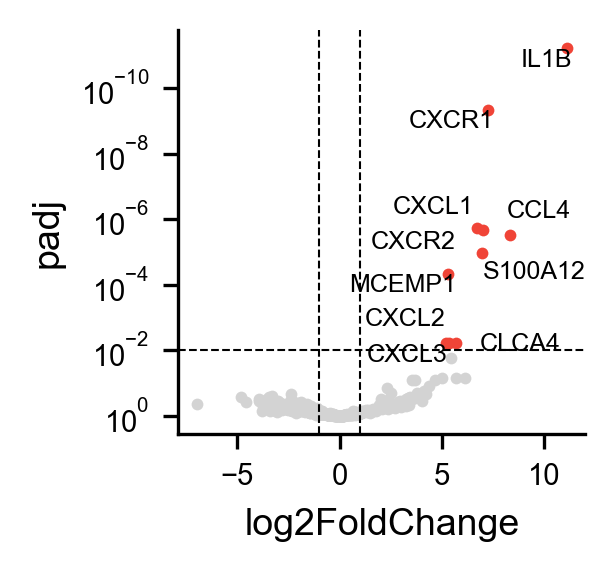

In [12]:
# Save results to plot
fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.75))
plot_volcano(data=data, logfc='log2FoldChange', pvals='padj', ax=ax)
fig.savefig(media_dir / dataset / 'neutrophil_de.svg')

#### Nuclear Fraction TX and In Nucleus

In [22]:
# Read in all transcripts
transcripts_filepath = data_dir / dataset / 'labeled_transcripts.parquet'
transcripts = pd.read_parquet(transcripts_filepath)

# Filter control probes and low QV probes
xe_settings = load_settings('xenium')
transcripts = filter_transcripts(
    transcripts,
    label=xe_settings.transcripts.label,
    filter_substrings=xe_settings.transcripts.filter_substrings,
    min_qv=25,
)
transcripts = transcripts[transcripts['score_cxg_k=20'].gt(0.5)]

# Get fraction each cell that are nuclear
seg_col = 'segger_cell_id_cxg_k=20'
frac = transcripts.groupby(seg_col)['overlaps_nucleus'].mean()
frac.index = frac.index.astype(str)
ad_seg.obs['fraction_nuclear_tx'] = frac

# Whether cell is also in 10X nucleus dataset
ad_seg.obs['in_10x_nucleus'] = ad_seg.obs['10x_id'].isin(ad_nuc.obs.index)

#### Marker Capture

In [279]:
# Get potential markers per cell type
filename = 'elmentaite_human_colon_atlas.h5ad'
ad_atl = sc.read_h5ad(data_dir / dataset / f'h5ads/{filename}')

In [280]:
# Subset to colon only
colon_tissues = [
    'sigmoid colon', 
    'ascending colon',
    'descending colon',
    'colon',
    'large intestine'
]
ad_atl = ad_atl[ad_atl.obs['tissue'].isin(colon_tissues)]

# Set gene names as var index
ad_atl.var.set_index('feature_name', inplace=True)

In [281]:
# Map author cell types to align with ours
cell_type_map = {
    'Activated CD4 T': 'CD4+ T Cell',
    'Activated CD8 T': 'CD8+ T Cell',
    'Activated T': 'NA',
    'Adult Glia': 'Glial Cell',
    'BEST2+ Goblet cell': 'Goblet Cell',
    'BEST4+ epithelial': 'BEST4+ Epithelial Cell',
    'Branch A1 (iMN)': 'NA',
    'Branch A2 (IPAN/IN)': 'NA',
    'Branch A3 (IPAN/IN)': 'NA',
    'Branch A4 (IN)': 'NA',
    'Branch B1 (eMN)': 'NA',
    'Branch B2 (eMN)': 'NA',
    'Branch B3 (IPAN)': 'NA',
    'CD8 Tmem': 'CD8+ T Cell',
    'CLC+ Mast cell': 'Mast Cell',
    'CLDN10+ cells': 'NA',
    'CLP': 'NA',
    'CX3CR1+ CD8 Tmem': 'CD8+ T Cell',
    'Colonocyte': 'Enterocyte',
    'Contractile pericyte (PLN+)': 'Pericyte',
    'Cycling B cell': 'Cycling Immune Cell',
    'D cells (SST+)': 'NA',
    'Differentiating glia': 'Glial Cell',
    'Distal progenitor': 'Transit Amplifying Cell',
    'EC cells (NPW+)': 'EC Cell',
    'EC cells (TAC1+)': 'EC Cell',
    'EECs': 'EC Cell',
    'ENCC/glia Progenitor': 'Glial Cell',
    'Enterocyte': 'Enterocyte',
    'Fetal arterial EC': 'Endothelial Cell',
    'Fetal venous EC': 'Endothelial Cell',
    'Germ': 'NA',
    'Glia 1 (DHH+)': 'Glial Cell',
    'Glia 2 (ELN+)': 'Glial Cell',
    'Glia 3 (BCAN+)': 'Glial Cell',
    'Goblet cell': 'Goblet Cell',
    'I cells (CCK+)': 'NA',
    'ICC': 'ICC',
    'ILC2': 'NA',
    'ILC3': 'NA',
    'ILCP': 'NA',
    'IgA plasma cell': 'Plasma Cell',
    'IgG plasma cell': 'Plasma Cell',
    'Immature B': 'B Cell',
    'Immature pericyte': 'Pericyte',
    'L cells (PYY+)': 'L Cell',
    'LEC1 (ACKR4+)': 'Endothelial Cell',
    'LEC2 (MADCAM1+)': 'Endothelial Cell',
    'LEC3 (ADGRG3+)': 'Endothelial Cell',
    'LEC4 (STAB2+)': 'Endothelial Cell',
    'LEC5 (CLDN11+)': 'Endothelial Cell',
    'LEC6 (ADAMTS4+)': 'Endothelial Cell',
    'LTi-like NCR+ ILC3': 'NA',
    'LTi-like NCR- ILC3': 'NA',
    'LYVE1+ Macrophage': 'LYVE1+ Macrophage',
    'Lymphoid DC': 'cDC',
    'M/X cells (MLN/GHRL+)': 'NA',
    'MAIT cell': 'NA',
    'MMP9+ Inflammatory macrophage': 'Macrophage',
    'MPO+ mono-neutrophil': 'Neutrophil',
    'Macrophages': 'Macrophage',
    'Mast cell': 'Mast Cell',
    'Mature arterial EC': 'Endothelial Cell',
    'Mature venous EC': 'Endothelial Cell',
    'Megakaryocyte': 'NA',
    'Memory B': 'B Cell',
    'Mesoderm 1 (HAND1+)': 'NA',
    'Mesoderm 2 (ZEB2+)': 'NA',
    'Mesothelium': 'NA',
    'Mesothelium (RGS5+)': 'NA',
    'Microfold cell': 'NA',
    'Monocytes': 'Monocyte',
    'N cells (NTS+)': 'NA',
    'NK T cell': 'NA',
    'NK cell': 'NA',
    'Naive B': 'B Cell',
    'Neuroblast': 'NA',
    'Paneth': 'Paneth Cell',
    'Pericyte': 'Pericyte',
    'Pre-B': 'B Cell',
    'Pro-B': 'B Cell',
    'Progenitor (NEUROG3+)': 'Stem Cell',
    'Proximal progenitor': 'Transit Amplifying Cell',
    'RBC': 'NA',
    'SELL+ CD4 T': 'CD4+ T Cell',
    'SELL+ CD8 T': 'CD8+ T Cell',
    'SMC (PART1/CAPN3+)': 'Smooth Muscle Cell',
    'SMC (PLPP2+)': 'Smooth Muscle Cell',
    'Stem cells': 'Stem Cell',
    'Stromal 1 (ADAMDEC1+)': 'Stromal 1',
    'Stromal 1 (CCL11+)': 'Stromal 1',
    'Stromal 2 (CH25H+)': 'Stromal 2',
    'Stromal 2 (NPY+)': 'Stromal 2',
    'Stromal 3 (C7+)': 'Stromal 3',
    'Stromal 3 (KCNN3+)': 'Stromal 3',
    'T reticular': 'NA',
    'TA': 'Transit Amplifying Cell',
    'TRDV2/TRGV9 gdT': 'NA',
    'TRGV2 gdT': 'NA',
    'TRGV4 gdT': 'NA',
    'TRGV5/7 gdT': 'NA',
    'Th1': 'CD4+ T Cell',
    'Th17': 'CD4+ T Cell',
    'Transitional Stromal 3 (C3+)': 'Stromal 3',
    'Treg': 'Treg',
    'Tuft': 'Tuft Cell',
    'angiogenic pericyte': 'Pericyte',
    'arterial capillary': 'Endothelial Cell',
    'cDC1': 'cDC',
    'cDC2': 'cDC',
    'cycling EC': 'Endothelial Cell',
    'cycling ENCC/glia': 'Glial Cell',
    'cycling neuroblast': 'NA',
    'cycling stromal': 'NA',
    'gdT': 'NA',
    'mLN Stroma (FMO2+)': 'NA',
    'mLTo': 'NA',
    'myofibroblast': 'Myofibroblast',
    'myofibroblast (RSPO2+)': 'Myofibroblast',
    'pDC': 'NA',
    'venous capillary': 'Endothelial Cell',
}

In [282]:
# Read in cell type markers from literature
filepath = data_dir / dataset / 'tables/cell_type_markers.csv'
markers = pd.read_csv(filepath)

# Map to coarse labels
ad_atl.obs['ct_simple'] = ad_atl.obs['author_cell_type'].map(cell_type_map)
for l in [1, 2]:
    counts = markers.groupby('group')[f'level_{l}'].value_counts()
    ct_map = counts.unstack().idxmax(1)  # coarse labels
    ad_atl.obs[f'cell_type_level_{l}'] = ad_atl.obs['ct_simple'].map(ct_map)

In [368]:
# Ignore performance warnings from calling insert
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Run diffex analysis
gb = 'cell_type_level_1'
sample = ad_atl.obs.groupby(gb).sample(1000, replace=True).index
sample = sample[~sample.duplicated()]
ad_atl_sample = ad_atl[sample].copy()
sc.pp.filter_genes(ad_atl_sample, min_counts=10)
sc.tl.rank_genes_groups(ad_atl_sample, gb, use_raw=False, method='wilcoxon')

# Summarize DEG results
markers_summary = pd.DataFrame(
    index=ad_atl_sample.obs[gb].unique(),
    columns=['No. scRNAseq', 'No. Xenium', 'Fraction'],
)
for ct in df.index:
    cutoffs = dict(pval_cutoff=1e-3, log2fc_min=3)
    genes = sc.get.rank_genes_groups_df(ad_atl_sample, ct, **cutoffs)['names']
    no_sc = len(genes)
    no_xe = len(ad_seg.var.index.intersection(genes))
    markers_summary.loc[ct] = no_sc, no_xe, no_xe / no_sc

... storing 'ct_simple' as categorical
... storing 'cell_type_level_1' as categorical
... storing 'cell_type_level_2' as categorical


### Figure 4G

#### Prepare Data

In [562]:
# Prepare data
df_1 = ad_seg.obs[['n_counts', 'cell_type_level_1']].copy()
df_1['x'] = df_1['cell_type_level_1'] == 'Neutrophil'
df_1['y'] = df_1['n_counts']

df_2 = ad_seg.obs[['fraction_nuclear_tx', 'cell_type_level_1']].copy()
df_2['x'] = df_2['cell_type_level_1'] == 'Neutrophil'
df_2['y'] = df_2['fraction_nuclear_tx'] * 100

df_3 = markers_summary
df_3['x'] = df_3.index == 'Neutrophil'
df_3['y'] = df_3['No. Xenium']

df_4 = ad_seg.obs.groupby('cell_type_level_1')[['in_10x_nucleus']].mean()
df_4['x'] = df_4.index == 'Neutrophil'
df_4['y'] = df_4['in_10x_nucleus'] * 100

for df in [df_1, df_2, df_3, df_4]:
    df['x'] = df['x'].map({True: 'Neutrophil', False: 'Rest'})

#### Plots

In [576]:
fig, axes = plt.subplots(
    2, 2,
    figsize=(2.75, 2.75),
    gridspec_kw=dict(hspace=0.33, wspace=0.75),
    sharex=True,
)

# Shared plotting arguments
shared_kwargs = dict(
    order=['Neutrophil', 'Rest'], x='x', y='y',
    palette=[named_colors['Cell Type']['Neutrophil'], 'lightgray'],
)
extra_ticks = []

# Bar Plots
barplt_kwargs = dict(capsize=0.2, width=0.6, errorbar='pi', errwidth=0.75)
barplt_kwargs.update(shared_kwargs)
for df, ax in zip([df_4, df_3], axes[:, 0]):
    sns.barplot(df, ax=ax, **barplt_kwargs)
    extra_ticks.append(df.loc['Neutrophil', 'y'])

# Violin Plots
violin_kwargs = dict(
    common_norm=False, bw_adjust=2, cut=0, linewidth=0.75, saturation=1.0,
    edgecolor=[1.]*3, density_norm='width', inner_kws=dict(color=[0.1]*3),
    width=0.75,
)
violin_kwargs.update(shared_kwargs)
for df, ax in zip([df_1, df_2], axes[:, 1]):
    sns.violinplot(df, ax=ax, **violin_kwargs)
    extra_ticks.append(df.loc[df['x'].eq('Neutrophil'), 'y'].mean())

# Formatting
yt = [
    np.arange(0, 101, 50),
    np.arange(0, 51, 25),
    np.arange(25, 226, 100),
    np.arange(0, 101, 50),
]
for ax, yticks, extra in zip(axes.T.flat, yt, extra_ticks):
    ax.set_ylim(yticks[0], yticks[1])
    ax.set_yticks(np.hstack([extra, yticks]))
    ax.set_ylabel('')
    ax.set_xlabel('')

fig.savefig(media_dir / dataset / f'neutrophil_metrics.svg', dpi=300)
plt.close()

### Correlation Matrices

In [144]:
mask = ad_seg.obs['cell_type_level_1'].eq('Neutrophil')
whitelist = ad_seg.obs.loc[mask, '10x_id']

mask = np.isin(ad_nuc.uns['raw_counts']['index'], whitelist)
counts = ad_nuc.uns['raw_counts']['count'][mask]

In [145]:
(counts < 10).mean()

0.46054181389870436

In [146]:
# Add Neutrophil label to compartments
col = 'cell_type_level_2'

for ad in [ad_seg, ad_nuc]:
    ad.obs[f'{col}_mod'] = ad.obs[col].astype(str)
    mask = ad.obs['cell_type_level_1'].eq('Neutrophil')
    ad.obs.loc[mask, f'{col}_mod'] = 'Neutrophil'

In [147]:
# Read in AnnData
name = '10x_nucleus_lo_thresh'
ad_nuc_lt = sc.read_h5ad(data_dir / dataset / f'h5ads/{name}_processed.h5ad')

In [154]:
# Split by no. counts
mask = ad_nuc_lt.obs['n_counts'].lt(25)
ad_nuc_lq = ad_nuc_lt[mask]
mask = ad_nuc_lt.obs['n_counts'].gt(25)
ad_nuc_hq = ad_nuc_lt[mask]

In [155]:
# Ignore performance warnings from calling insert
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Build correlation matrices
col = 'cell_type_level_2_mod'
ad_nuc.X = ad_nuc.layers['lognorm']
sc.tl.rank_genes_groups(ad_nuc, col, use_raw=False, method='wilcoxon')

In [156]:
# Build Series of markers
genes = dict()
logfc = dict()
for ct in ad_nuc.obs[col].unique():
    degs = sc.get.rank_genes_groups_df(ad_nuc, ct)
    mask = degs.logfoldchanges.gt(1) & degs.pvals.lt(1e-2)
    genes[ct] = degs[mask].names.tolist()
    logfc[ct] = degs[mask].logfoldchanges.tolist()

genes = pd.Series(genes).explode()
logfc = pd.Series(logfc).explode()
markers = pd.concat([genes, logfc], axis=1).reset_index()
markers.columns = ['cell_type', 'gene', 'logfc']
markers = markers.sort_values('logfc', ascending=False)
markers = markers[~markers.gene.duplicated()].dropna()
markers = markers.sort_values('cell_type')

In [166]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Get groupwise dendrogram
counts = markers['cell_type'].value_counts(sort=False)
groups = counts.index
splits = [0] + counts.values.tolist()
splits = np.cumsum(splits[:-1])

C = np.corrcoef(ad_nuc_hq[:, markers.gene].layers['norm'].todense().A.T)
C_agg = np.add.reduceat(
    np.add.reduceat(C, splits, axis=0),
    splits,
    axis=1,
)
cm = dendrogram(linkage(C_agg, method='average'), no_plot=True)
group_order = groups[cm['leaves']]

order = []
for name in tqdm(group_order):
    group = markers.groupby('cell_type').get_group(name)
    X = ad_nuc_hq[:, group.gene].layers['norm'].todense().A.T
    C = np.corrcoef(X)
    cm = dendrogram(linkage(C, method='single'), no_plot=True)
    idx = cm['leaves']
    order += group.gene.iloc[idx].tolist()

100%|██████████| 8/8 [00:01<00:00,  7.65it/s]


In [167]:
from matplotlib.colors import to_rgb
palette = named_colors['Compartment']
palette['Neutrophil'] = named_colors['Cell Type']['Neutrophil']

annot = markers.set_index('gene').loc[order, 'cell_type'].map(palette)
annot = annot.apply(to_rgb).explode()
annot = annot.values.reshape(markers.shape[0], 3)
annot = annot[np.newaxis, :, :].astype(float)

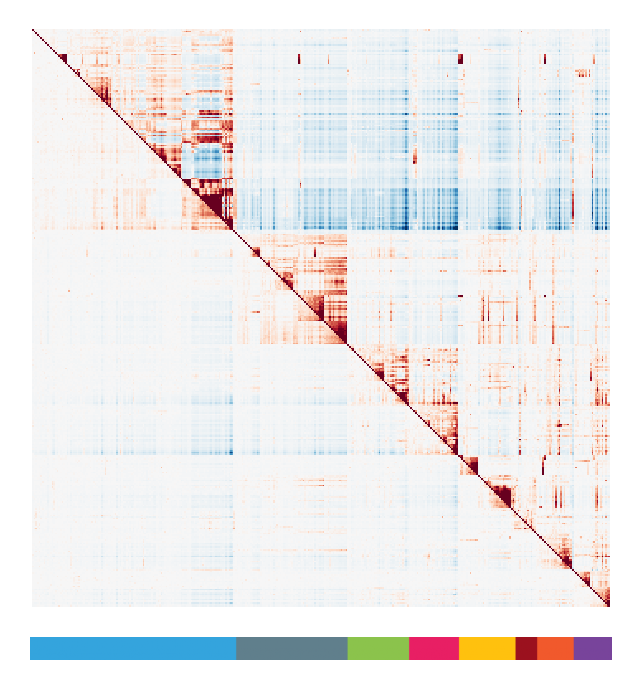

In [168]:
heights = [2.5, 0.1]
fig, axes = plt.subplots(
    2, 1,
    figsize=(2.5, np.sum(heights) + np.mean(heights) * 0.1),
    gridspec_kw=dict(height_ratios=heights, hspace=0.1),
)

layer='norm'
C_upper = np.corrcoef(ad_nuc_hq[:, order].layers[layer].todense().A.T)
C_lower = np.corrcoef(ad_nuc_lq[:, order].layers[layer].todense().A.T)
C = np.triu(C_upper, k=0) + np.tril(C_lower, k=-1)

v = np.quantile(np.abs(C_upper), 0.99)
axes[0].imshow(C, vmin=-v, vmax=v, cmap='RdBu_r', interpolation='none') #, ax=axes[0])
axes[0].axis('off')

axes[1].imshow(annot, aspect='auto')
axes[1].axis('off')

fig.savefig(media_dir / dataset / 'covariance.svg')

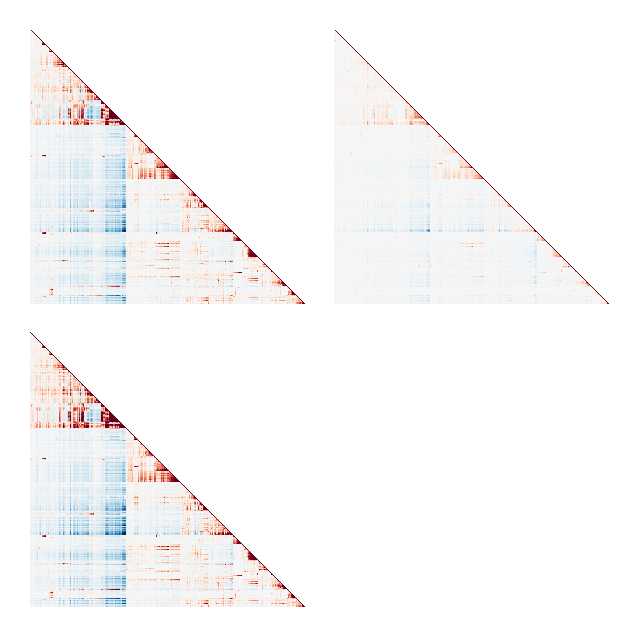

In [179]:
heights = [2.5, 0.1]
fig, axes = plt.subplots(
    2, 2,
    figsize=(2.5, 2.5),
    gridspec_kw=dict(hspace=0.1, wspace=0.1),
)

layer='norm'
C_nuc_hq = np.corrcoef(ad_nuc_hq[:, order].layers[layer].todense().A.T)
C_nuc_lq = np.corrcoef(ad_nuc_lq[:, order].layers[layer].todense().A.T)
C_seg = np.corrcoef(ad_seg[:, order].layers[layer].todense().A.T)

v = np.quantile(np.abs(C_seg), 0.99)
for ax, C in zip(axes.flat, [C_nuc_hq, C_nuc_lq, C_seg]):
    ax.imshow(
        np.where(np.tril(C) != 0, np.tril(C), np.nan), 
        vmin=-v, vmax=v, 
        cmap='RdBu_r',
        interpolation='none',
    )
    ax.axis('off')

axes.flat[-1].axis('off')
fig.savefig(media_dir / dataset / 'supp_fig4f.svg')

## Tuft Cell Contamination

In [4]:
from pydeseq2.default_inference import DefaultInference
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [22]:
mask = ad_seg.obs['cell_type_level_1'].eq('Tuft')
idx = ad_seg.obs.loc[mask, '10x_id'].values
ad_seg.layers['raw'] = ad_seg.raw.X.copy()

n = 5
ad_seg.obs['pseudosample'] = np.random.randint(0, n, ad_seg.obs.shape[0])
counts_seg = sc.get.aggregate(ad_seg[mask], 'pseudosample', 'sum', layer='raw').to_df(layer='sum')
metadata_seg = pd.DataFrame('Segger', counts_seg.index, columns=['condition'])

In [23]:
mask = ad_10x.obs['cell_type_level_1'].eq('Tuft')
idx = ad_10x.obs.loc[mask, '10x_id'].values
ad_10x.layers['raw'] = ad_10x.raw.X.copy()

ad_10x.obs['pseudosample'] = np.random.randint(0, n, ad_10x.obs.shape[0])
counts_10x = sc.get.aggregate(ad_10x[idx], 'pseudosample', 'sum', layer='raw').to_df(layer='sum')
metadata_10x = pd.DataFrame('10X', counts_10x.index, columns=['condition'])

In [24]:
counts = pd.concat([counts_seg, counts_10x]).astype(int)
metadata = pd.concat([metadata_seg, metadata_10x])

In [25]:
# Run DeSeq2
with HiddenPrints():
    inference = DefaultInference(n_cpus=32)
    dds = DeseqDataSet(
        counts=counts,
        metadata=metadata,
        design_factors="condition",
        refit_cooks=True,
        inference=inference,
        quiet=True,
    )
    dds.deseq2()
    stat_res = DeseqStats(dds)
    stat_res.summary()
    data = stat_res.results_df

Running Wald tests...
... done in 10.19 seconds.



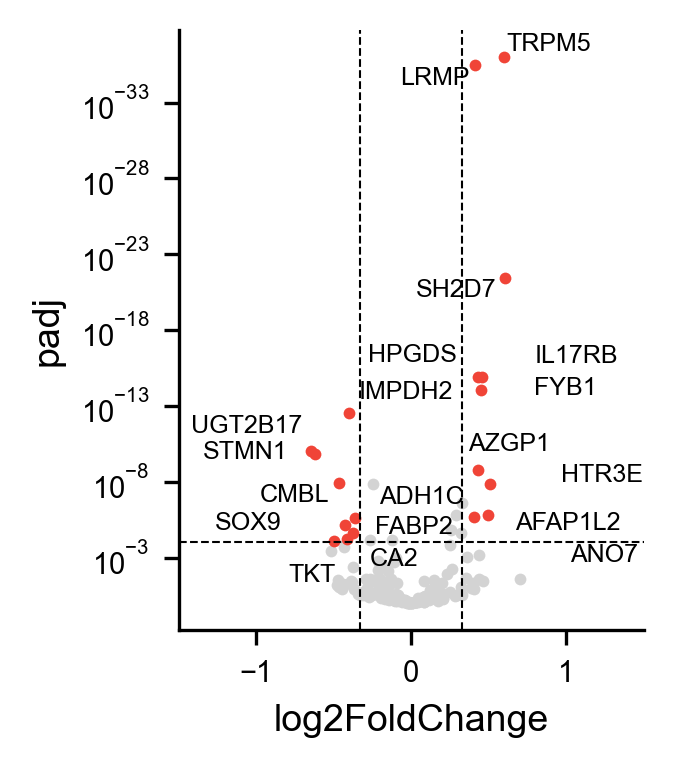

In [28]:
# Save results to plot
fig, ax = plt.subplots(1, 1, figsize=(2, 2.6))
plot_volcano(data=data, logfc='log2FoldChange', pvals='padj', ax=ax, logfc_min=0.33, pvals_min=1e-4)
ax.set_xlim(-1.5, 1.5)
ax.tick_params(labelsize=7)
fig.savefig(media_dir / dataset / 'tuft_de.svg')

In [34]:
# Custom palette
palette = named_colors['Cell Type'].copy()
palette['Tuft'] = 'w'

In [37]:
# Spatial subset
xmin = 7200
xmax = 9200
ymin = 2500
ymax = 4500

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
shared_kwargs = dict(
    features='cell_type_level_1',
    basis='X_spatial',
    palette=palette,
    rasterized=True,
    legend_loc='',
    ax=ax,
)

_ = plot_embedding(ad_10x, s=1, **shared_kwargs)
mask = ad_10x.obs['cell_type_level_1'].eq('Tuft')
_ = plot_embedding(ad_10x[mask], s=5, **shared_kwargs)

# Formatting
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_facecolor('k')
ax.set_title('')

# Save
fig.savefig(media_dir / dataset / f'10X_cell_type_space.svg', dpi=300)
plt.close()

In [47]:
# Custom cmap
from matplotlib.colors import LinearSegmentedColormap
cmap = sns.color_palette('viridis', as_cmap=True)
colors = [cmap(n) for n in np.linspace(0.05, 1.0, 255)]
cmap = LinearSegmentedColormap.from_list('', colors, 255)

In [49]:
shared_kwargs = dict(
    basis='X_spatial',
    layer='lognorm',
    rasterized=True,
    legend_loc='',
    vmax='p99.9',
    cbar=False,
    cmap=cmap,
    sort_order=False,
)

# Spatial subset
xmin = 7200
xmax = 9200
ymin = 2500
ymax = 4500

for gene in ['IMPDH2']:
    # Underlay
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    _ = plot_embedding(ad_seg, features=gene, s=1, ax=ax, **shared_kwargs)
    
    # Formatting
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_facecolor('k')
    ax.set_title('')

    # Save
    fig.savefig(media_dir / dataset / f'{gene}_expression.svg', dpi=300)
    plt.close()